# Feature Creation

## Blob Credentials

In [0]:
blob_container = "blobcontainer" # The name of your container created in https://portal.azure.com
storage_account = "w261section05group03" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261section05group04" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "houseofthedragon" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))

path name size modificationTime dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data/ parquet_airlines_data/ 0 1656618287000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_1y/ parquet_airlines_data_1y/ 0 1656630272000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_3m/ parquet_airlines_data_3m/ 0 1656630114000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_6m/ parquet_airlines_data_6m/ 0 1656630205000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data/ parquet_weather_data/ 0 1656622074000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_1y/ parquet_weather_data_1y/ 0 1656631614000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_3m/ parquet_weather_data_3m/ 0 1656630651000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_6m/ parquet_weather_data_6m/ 0 1656631047000 dbfs:/mnt/mids-w261/datasets_final_project_2022/stations_data/ stations_data/ 0 1656713663000

In [0]:
# !pip install -U airportsdata
# import airportsdata
from pyspark.sql.functions import col,isnan,when,count, lit, concat, col, to_timestamp, monotonically_increasing_id, datediff, mean, sum
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
 
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
import time
import numpy as np 
import pandas as pd
import seaborn as sns
from pytz import timezone 
from datetime import  datetime, timedelta 
import os
import networkx as nx
from delta.tables import DeltaTable
from copy import deepcopy


data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"
# display(dbutils.fs.ls(f"{data_BASE_DIR}"))


#get timezone
# gadb = airportsdata.load()
# df_gadb = pd.DataFrame.from_dict(gadb).transpose()


airport_codes = spark.table("hive_metastore.default.airport_codes")

#get rid of blank iata codes
# df_gadb = df_gadb[df_gadb['iata'] != ""]
# df_gadb = spark.createDataFrame(df_gadb)
# df_gadb.distinct()

df_airlines = spark.read.parquet(f"{data_BASE_DIR}parquet_airlines_data/").distinct()
df_stations = spark.read.parquet(f"{data_BASE_DIR}stations_data/*")

df_timezone = spark.read.parquet(f"{blob_url}/airport_codes_timezone").withColumnRenamed("airport_tz", "tz").select('iata', 'tz').distinct()

# df_stations_icao = df_stations.select('neighbor_id', 'neighbor_call').distinct()

# Drop all columns but neighbor id and icao
df_stations_icao = df_stations.select('neighbor_id', 'neighbor_call').distinct()

# # Add valid ICAO to weather data
# df_weather_icao = df_stations_icao.join(df_weather,\
#                                            df_weather.STATION == df_stations_icao.neighbor_id,\
#                                            'left').where('neighbor_id IS NOT NULL')

# Merge airlines and codes
df_airlines = df_airlines.join(airport_codes,\
                                     df_airlines.ORIGIN == airport_codes.iata_code,\
                                     'left')

#Pull in timezone
df_airlines = df_airlines.join(df_timezone,\
                                     df_airlines.ORIGIN == df_timezone.iata,\
                                     'left').drop('iata')

def get_hour_minutes(depature_time):
    depature_time = str(depature_time)
    hour = ''
    if len(depature_time) <= 2:
      hour = '00'
      minutes = depature_time
    elif len(depature_time) == 3:
      hour = depature_time[0]
      minutes = depature_time[1:]
    elif len(depature_time) == 4:
      hour = depature_time[:2]
      minutes = depature_time[2:]
    return hour, minutes
  
def get_timestamp(year, month, day, hour_minutes, tz):
  hour, minutes = get_hour_minutes(hour_minutes)
  utc = timezone('UTC')
  tz = timezone(tz)
  timestamp = tz.localize(datetime(int(year), int(month), int(day), hour=int(hour), minute=int(minutes)))
  return timestamp.astimezone(utc)

def get_hour_timestamp(year, month, day, hour_minutes, tz):
  hour, minutes = get_hour_minutes(hour_minutes)
  utc = timezone('UTC')
  tz = timezone(tz)
  timestamp = tz.localize(datetime(int(year), int(month), int(day), hour=int(hour)))
  return timestamp.astimezone(utc)

def get_weather_timestamp(depature_timestamp, hours = 2):
  return (depature_timestamp - timedelta(hours=hours))

def go_back_an_hour(depature_timestamp):
  return (depature_timestamp - timedelta(hours=1))
 
def get_string_timestamp(timestamp):
  return timestamp.strftime("%Y%m%d%H%M")

def get_hourly_string_timestamp(timestamp):
  return timestamp.strftime("%Y%m%d%H")

def get_hour(depature_time):
    depature_time = str(depature_time)
    hour = ''
    if len(depature_time) <= 2:
      hour = '00'
    elif len(depature_time) == 3:
      hour = depature_time[0]
    elif len(depature_time) == 4:
      hour = depature_time[:2]
    return hour

get_hour = udf(get_hour)
get_timestamp = udf(get_timestamp)
get_hour_timestamp = udf(get_hour_timestamp)
get_weather_timestamp = udf(get_weather_timestamp)
get_string_timestamp = udf(get_string_timestamp)
get_hourly_string_timestamp = udf(get_hourly_string_timestamp)
go_back_an_hour = udf(go_back_an_hour)


# get_flight_hour = udf(get_flight_hour)

# Create the timestamp columns for the flight data
df_airlines = df_airlines.withColumn("FLIGHT_TIMESTAMP", get_timestamp("YEAR", "MONTH", "DAY_OF_MONTH", "CRS_DEP_TIME", "tz"))
df_airlines = df_airlines.withColumn("FLIGHT_TIMESTAMP", get_string_timestamp("FLIGHT_TIMESTAMP"))
df_airlines = df_airlines.withColumn("FLIGHT_TIMESTAMP", to_timestamp(col("FLIGHT_TIMESTAMP"), "yyyyMMddHHmm"))
# df_airlines.cache()


                               
df_airport_timezone = spark.read.parquet(f"{blob_url}/airport_codes_timezone")

In [0]:
obs_count = df_airlines.count()
features_count = len(df_airlines.columns)

print(f' Number of observations: {obs_count}')
print(f' Number of features: {features_count}')

 Number of observations: 42430592
 Number of features: 125


## Drop Cancelled Flights that do not have minutes in delay.

In [0]:
# Roughly 2% of cancelled also flights were also delayed by at least 15 minutes. we will keep these cancelled flights
df_airlines = df_airlines.filter(~((df_airlines.CANCELLED == 1) & (df_airlines.DEP_DEL15.isNull())))

In [0]:
obs_count = df_airlines.count()
features_count = len(df_airlines.columns)

print(f' Number of observations: {obs_count}')
print(f' Number of features: {features_count}')

 Number of observations: 41577397
 Number of features: 123


In [0]:
feature_to_drop = ('FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME', 'DIV_AIRPORT_LANDINGS', 'DIV_REACHED_DEST','DIV_ACTUAL_ELAPSED_TIME',
                       'DIV_ARR_DELAY','DIV_DISTANCE', 'DIV1_AIRPORT', 'DIV1_AIRPORT_ID', 'DIV1_AIRPORT_SEQ_ID', 'DIV1_WHEELS_ON',
                       'DIV1_TOTAL_GTIME','DIV1_LONGEST_GTIME', 'DIV1_WHEELS_OFF','DIV1_TAIL_NUM', 'DIV2_AIRPORT', 'DIV2_AIRPORT_ID', 'DIV2_AIRPORT_SEQ_ID',
                       'DIV2_WHEELS_ON', 'DIV2_TOTAL_GTIME','DIV2_LONGEST_GTIME', 'DIV2_WHEELS_OFF','DIV2_TAIL_NUM', 'DIV3_AIRPORT', 'DIV3_AIRPORT_ID',
                       'DIV3_AIRPORT_SEQ_ID', 'DIV3_WHEELS_ON', 'DIV3_TOTAL_GTIME','DIV3_LONGEST_GTIME', 'DIV3_WHEELS_OFF','DIV3_TAIL_NUM', 'DIV4_AIRPORT',
                       'DIV4_AIRPORT_ID','DIV4_AIRPORT_SEQ_ID','DIV4_WHEELS_ON','DIV4_TOTAL_GTIME','DIV4_LONGEST_GTIME','DIV4_WHEELS_OFF',
                       'DIV4_TAIL_NUM','DIV5_AIRPORT','DIV5_AIRPORT_ID','DIV5_AIRPORT_SEQ_ID','DIV5_WHEELS_ON','DIV5_TOTAL_GTIME','DIV5_LONGEST_GTIME',
                       'DIV5_WHEELS_OFF','DIV5_TAIL_NUM', 'OP_CARRIER','OP_CARRIER_FL_NUM','ORIGIN_AIRPORT_SEQ_ID',
                       'ORIGIN_CITY_MARKET_ID','ORIGIN_CITY_NAME','ORIGIN_STATE_FIPS','ORIGIN_STATE_NM','ORIGIN_WAC','DEST_AIRPORT_SEQ_ID',
                       'DEST_CITY_MARKET_ID','DEST_CITY_NAME','DEST_STATE_FIPS','DEST_STATE_NM','DEST_WAC','TAXI_OUT','WHEELS_OFF','WHEELS_ON',
                       'TAXI_IN','CANCELLATION_CODE','CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME','AIR_TIME','FLIGHTS')

df_airlines = df_airlines.drop(*feature_to_drop)



In [0]:
df_missing = df_airlines.select(*[
    (
        count(when((isnan(c) | col(c).isNull()), c)) if t not in ("timestamp", "date")
        else count(when(col(c).isNull(), c))
    ).alias(c)
    for c, t in df_airlines.dtypes if c in df_airlines.columns
]).toPandas()



In [0]:
df_missing_only = df_missing.loc[0] 
df_missing_only = df_missing_only[df_missing_only != 0]
with pd.option_context('display.max_rows', None,):
    print(df_missing_only)

TAIL_NUM                      2
DEP_DELAY                  4744
DEP_DELAY_NEW              4744
DEP_DEL15                  4744
DEP_DELAY_GROUP            4744
ARR_TIME                  34982
ARR_DELAY                123402
ARR_DELAY_NEW            123402
ARR_DEL15                123402
ARR_DELAY_GROUP          123402
CARRIER_DELAY          34336032
WEATHER_DELAY          34336032
NAS_DELAY              34336032
SECURITY_DELAY         34336032
LATE_AIRCRAFT_DELAY    34336032
elevation_ft                  1
Name: 0, dtype: int64


In [0]:
from pyspark.sql.functions import col,isnan,when,count, lit, concat, col, to_timestamp, monotonically_increasing_id, datediff, mean, sum

df_airlines = df_airlines.withColumn("calc_dep_delay", col("CRS_DEP_TIME") - col("DEP_TIME"))
# df_airlines.filter(df_airlines.DEP_DELAY.isNull()).select("calc_dep_delay").collect()

In [0]:
display(df_airlines.filter(df_airlines.DEP_DELAY.isNull()).sort(['calc_dep_delay'], ascending =False))

QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID TAIL_NUM ORIGIN_AIRPORT_ID ORIGIN ORIGIN_STATE_ABR DEST_AIRPORT_ID DEST DEST_STATE_ABR CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR ident type name elevation_ft continent iso_country iso_region municipality gps_code iata_code local_code coordinates tz FLIGHT_TIMESTAMP calc_dep_delay 3 7 27 5 2018-07-27 F9 20436 N938FR 13204 MCO FL 10423 AUS TX 1825 33 null null null null 1800-1859 2019 null null null null null 2000-2059 0.0 1.0 994.0 4 null null null null null 2018 KMCO large_airport Orlando International Airport 96 NA US US-FL Orlando KMCO MCO MCO -81.30899810791016, 28.429399490356445 America/New_York 2018-07-27T22:25:00.000+0000 1792 1 3 19 1 2018-03-19 9E 20363 N314PQ 15016 STL MO 12953 LGA NY 1650 1650 null null null null 1600-1659 2020 2027 7.0 7.0 0.0 0 2000-2059 0.0 0.0 888.0 4 null null null null null 2018 KSTL large_airport St Louis Lambert International Airport 618 NA US US-MO St Louis KSTL STL STL -90.370003, 38.748697 America/Chicago 2018-03-19T21:50:00.000+0000 0 3 7 24 2 2018-07-24 9E 20363 N295PQ 13487 MSP MN 11637 FAR ND 1122 1122 null null null null 1100-1159 1230 1216 -14.0 0.0 0.0 -1 1200-1259 0.0 0.0 223.0 1 null null null null null 2018 KMSP large_airport Minneapolis-St Paul International/Wold-Chamberlain Airport 841 NA US US-MN Minneapolis KMSP MSP MSP -93.221802, 44.882 America/Chicago 2018-07-24T16:22:00.000+0000 0 1 3 31 6 2018-03-31 9E 20363 N937XJ 13930 ORD IL 11433 DTW MI 1645 1645 null null null null 1600-1659 1911 1900 -11.0 0.0 0.0 -1 1900-1959 0.0 0.0 235.0 1 null null null null null 2018 KORD large_airport Chicago O'Hare International Airport 672 NA US US-IL Chicago KORD ORD ORD -87.9048, 41.9786 America/Chicago 2018-03-31T21:45:00.000+0000 0 1 3 12 1 2018-03-12 9E 20363 N925XJ 12478 JFK NY 11278 DCA VA 805 805 null null null null 0800-0859 937 920 -17.0 0.0 0.0 -2 0900-0959 0.0 0.0 213.0 1 null null null null null 2018 KJFK large_airport John F Kennedy International Airport 13 NA US US-NY New York KJFK JFK JFK -73.7789, 40.639801 America/New_York 2018-03-12T12:05:00.000+0000 0 1 3 9 5 2018-03-09 9E 20363 N330PQ 12478 JFK NY 10693 BNA TN 830 830 null null null null 0800-0859 1019 1006 -13.0 0.0 0.0 -1 1000-1059 0.0 0.0 765.0 4 null null null null null 2018 KJFK large_airport John F Kennedy International Airport 13 NA US US-NY New York KJFK JFK JFK -73.7789, 40.639801 America/New_York 2018-03-09T13:30:00.000+0000 0 3 7 20 5 2018-07-20 9E 20363 N133EV 12953 LGA NY 15016 STL MO 1407 1407 null null null null 1400-1459 1554 1547 -7.0 0.0 0.0 -1 1500-1559 0.0 0.0 888.0 4 null null null null null 2018 KLGA large_airport La Guardia Airport 21 NA US US-NY New York KLGA LGA LGA -73.872597, 40.777199 America/New_York 2018-07-20T18:07:00.000+0000 0 1 3 18 7 2018-03-18 9E 20363 N8839E 13487 MSP MN 10408 ATW WI 1535 1535 null null null null 1500-1559 1639 1645 6.0 6.0 0.0 0 1600-1659 0.0 0.0 236.0 1 null null null null null 2018 KMSP large_airport Minneapolis-St Paul International/Wold-Chamberlain Airport 841 NA US US-MN Minneapolis KMSP MSP MSP -93.221802, 44.882 America/Chicago 2018-03-18T20:35:00.000+0000 0 1 3 12 1 2018-03-12 9E 20363 N602LR 10431 AVL NC 10397 ATL GA 615 615 null null null null 0600-0659 721 708 -13.0 0.0 0.0 -1 0700-0759 0.0 0.0 164.0 1 null null null null null 2018 KAVL large_airport Asheville Regional Airport 2165 NA US US-NC Asheville KAVL AVL AVL -82.541801, 35.436199 America/New_York 2018-03-12T10:15:00.000+0000 0 1 3 14 3 2018-03-14 9E 20363 N922XJ 10397 ATL GA 10868 CAE SC 1734 1734 null null null null 1700-1759 1837 1824 -13.0 0.0 0.0 -1 1800-1859 0.0 0.0 192.0 1 null null null null null 2018 KATL large_airport Hartsfield Jackson Atlanta International

In [0]:
df_airlines = df_airlines.withColumn("calc_arr_delay", col("CRS_ARR_TIME") - col("ARR_TIME"))
display(df_airlines.filter(df_airlines.ARR_DELAY.isNull()).sort(['calc_arr_delay'], ascending =False))

QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID TAIL_NUM ORIGIN_AIRPORT_ID ORIGIN ORIGIN_STATE_ABR DEST_AIRPORT_ID DEST DEST_STATE_ABR CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR ident type name elevation_ft continent iso_country iso_region municipality gps_code iata_code local_code coordinates tz FLIGHT_TIMESTAMP calc_dep_delay calc_arr_delay 1 1 3 5 2020-01-03 00:00:00 OO 20304 N121SY 14771 SFO CA 14570 RNO NV 2245 2250 5.0 5.0 0.0 0 2200-2259 2355 23 null null null null 2300-2359 0.0 1.0 192.0 1 null null null null null 2020 KSFO large_airport San Francisco International Airport 13 NA US US-CA San Francisco KSFO SFO SFO -122.375, 37.61899948120117 America/Los_Angeles 2020-01-04T06:45:00.000+0000 -5 2332 2 5 5 4 2016-05-05 AS 19930 N472AS 14679 SAN CA 14747 SEA WA 2040 2031 -9.0 0.0 0.0 -1 2000-2059 2332 2 null null null null 2300-2359 0.0 1.0 1050.0 5 null null null null null 2016 KSAN large_airport San Diego International Airport 17 NA US US-CA San Diego KSAN SAN SAN -117.190002441, 32.7336006165 America/Los_Angeles 2016-05-06T03:40:00.000+0000 9 2330 3 9 11 1 2017-09-11 AA 19805 N161AA 14100 PHL PA 14771 SFO CA 2050 2048 -2.0 0.0 0.0 -1 2000-2059 2354 25 null null null null 2300-2359 0.0 1.0 2521.0 11 null null null null null 2017 KPHL large_airport Philadelphia International Airport 36 NA US US-PA Philadelphia KPHL PHL PHL -75.24109649658203, 39.87189865112305 America/New_York 2017-09-12T00:50:00.000+0000 2 2329 1 3 26 5 2021-03-26 00:00:00 F9 20436 N361FR 11292 DEN CO 14869 SLC UT 2222 2220 -2.0 0.0 0.0 -1 2200-2259 2354 27 null null null null 2300-2359 0.0 1.0 391.0 2 null null null null null 2021 KDEN large_airport Denver International Airport 5431 NA US US-CO Denver KDEN DEN DEN -104.672996521, 39.861698150635 America/Denver 2021-03-27T04:22:00.000+0000 2 2327 1 1 16 4 2020-01-16 00:00:00 OO 20304 N204SY 12892 LAX CA 14683 SAT TX 1900 1858 -2.0 0.0 0.0 -1 1900-1959 2351 26 null null null null 2300-2359 0.0 1.0 1211.0 5 null null null null null 2020 KLAX large_airport Los Angeles International Airport 125 NA US US-CA Los Angeles KLAX LAX LAX -118.407997, 33.942501 America/Los_Angeles 2020-01-17T03:00:00.000+0000 42 2325 3 7 21 2 2015-07-21 AS 19930 N585AS 14679 SAN CA 14747 SEA WA 2055 2048 -7.0 0.0 0.0 -1 2000-2059 2331 6 null null null null 2300-2359 0.0 1.0 1050.0 5 null null null null null 2015 KSAN large_airport San Diego International Airport 17 NA US US-CA San Diego KSAN SAN SAN -117.190002441, 32.7336006165 America/Los_Angeles 2015-07-22T03:55:00.000+0000 7 2325 4 10 19 1 2015-10-19 WN 19393 N244WN 11697 FLL FL 10821 BWI MD 2100 2054 -6.0 0.0 0.0 -1 2100-2159 2335 11 null null null null 2300-2359 0.0 1.0 925.0 4 null null null null null 2015 KFLL large_airport Fort Lauderdale Hollywood International Airport 9 NA US US-FL Fort Lauderdale KFLL FLL FLL -80.152702, 26.072599 America/New_York 2015-10-20T01:00:00.000+0000 46 2324 2 5 6 5 2016-05-06 WN 19393 N706SW 10397 ATL GA 13487 MSP MN 2155 2154 -1.0 0.0 0.0 -1 2100-2159 2330 6 null null null null 2300-2359 0.0 1.0 907.0 4 null null null null null 2016 KATL large_airport Hartsfield Jackson Atlanta International Airport 1026 NA US US-GA Atlanta KATL ATL ATL -84.428101, 33.6367 America/New_York 2016-05-07T01:55:00.000+0000 1 2324 1 1 7 2 2020-01-07 00:00:00 WN 19393 N769SW 13204 MCO FL 10693 BNA TN 2250 2245 -5.0 0.0 0.0 -1 2200-2259 2350 28 null null null null 2300-2359 0.0 1.0 616.0 3 null null null null null 2020 KMCO large_airport Orlando International Airport 96 NA US US-FL Orlando KMCO MCO MCO -81.30899810791016, 28.429399490356445 America/New_York 2020-01-08T03:50:00.000+0000 5 2322 4 10 23 2 2018-10-23 DL 19790 N686DA 10397 ATL GA 14771 SFO CA 2114 2111 -3.0 0.0 0.0 -1 2100-2

## FILL NA WITH 0s for DELAY CATEGORIES/ DROP NA for missing scheduled departure and arrival times.

In [0]:
df_airlines = df_airlines.na.drop(subset=["CRS_DEP_TIME"]).na.drop(subset=["CRS_ARR_TIME"])\
                         .na.drop(subset=["DEP_DELAY"]).fillna(0, subset=["CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"])\
                         .filter(col('DIVERTED') == 0)

In [0]:
df_missing = df_airlines.select(*[
    (
        count(when((isnan(c) | col(c).isNull()), c)) if t not in ("timestamp", "date")
        else count(when(col(c).isNull(), c))
    ).alias(c)
    for c, t in df_airlines.dtypes if c in df_airlines.columns
]).toPandas()

df_missing_only = df_missing.loc[0] 
df_missing_only = df_missing_only[df_missing_only != 0]
with pd.option_context('display.max_rows', None,):
    print(df_missing_only)

ARR_TIME           20849
ARR_DELAY          23311
ARR_DELAY_NEW      23311
ARR_DEL15          23311
ARR_DELAY_GROUP    23311
calc_arr_delay     20849
Name: 0, dtype: int64


## The resulting nulls for arrival delay are due to flights arriving ontime!

In [0]:
display(df_airlines.filter(df_airlines.ARR_TIME.isNull()))

QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID TAIL_NUM ORIGIN_AIRPORT_ID ORIGIN ORIGIN_STATE_ABR DEST_AIRPORT_ID DEST DEST_STATE_ABR CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR ident type name elevation_ft continent iso_country iso_region municipality gps_code iata_code local_code coordinates tz FLIGHT_TIMESTAMP calc_dep_delay calc_arr_delay 1 1 5 5 2018-01-05 OO 20304 N752SK 14108 PIA IL 13930 ORD IL 1812 1915 1503.0 1503.0 1.0 12 1800-1859 1918 null null null null null 1900-1959 1.0 0.0 130.0 1 0.0 0.0 0.0 0.0 0.0 2018 KPIA large_airport General Wayne A. Downing Peoria International Airport 660 NA US US-IL Peoria KPIA PIA PIA -89.6932983398, 40.664199829100006 America/Chicago 2018-01-06T00:12:00.000+0000 -103 null 1 2 20 2 2018-02-20 OO 20304 N869AS 15919 XNA AR 13930 ORD IL 1805 1844 1479.0 1479.0 1.0 12 1800-1859 1956 null null null null null 1900-1959 1.0 0.0 522.0 3 0.0 0.0 0.0 0.0 0.0 2018 KXNA medium_airport Northwest Arkansas Regional Airport 1287 NA US US-AR Fayetteville/Springdale/Rogers KXNA XNA XNA -94.306801, 36.281898 America/Chicago 2018-02-21T00:05:00.000+0000 -39 null 3 8 7 6 2021-08-07 00:00:00 AA 19805 N807AW 14492 RDU NC 12892 LAX CA 600 637 1477.0 1477.0 1.0 12 0600-0659 819 null null null null null 0800-0859 1.0 0.0 2239.0 9 0.0 0.0 0.0 0.0 0.0 2021 KRDU large_airport Raleigh Durham International Airport 435 NA US US-NC Raleigh/Durham KRDU RDU RDU -78.7874984741211, 35.877601623535156 America/New_York 2021-08-07T10:00:00.000+0000 -37 null 3 9 22 6 2018-09-22 EV 20366 N718EV 12217 HSV AL 11298 DFW TX 1341 1400 1459.0 1459.0 1.0 12 1300-1359 1531 null null null null null 1500-1559 1.0 0.0 603.0 3 0.0 0.0 0.0 0.0 0.0 2018 KHSV large_airport Huntsville International Carl T Jones Field 629 NA US US-AL Huntsville KHSV HSV HSV -86.775100708008, 34.637199401855 America/Chicago 2018-09-22T18:41:00.000+0000 -59 null 3 8 1 6 2020-08-01 00:00:00 AA 19805 N819AW 12339 IND IN 14107 PHX AZ 840 844 1444.0 1444.0 1.0 12 0800-0859 919 null null null null null 0900-0959 1.0 0.0 1488.0 6 0.0 0.0 0.0 0.0 0.0 2020 KIND large_airport Indianapolis International Airport 797 NA US US-IN Indianapolis KIND IND IND -86.294403, 39.7173 America/New_York 2020-08-01T12:40:00.000+0000 -4 null 3 8 4 7 2019-08-04 AA 19805 N866NN 11638 FAT CA 11298 DFW TX 1134 1015 1361.0 1361.0 1.0 12 1100-1159 1650 null null null null null 1600-1659 1.0 0.0 1313.0 6 0.0 0.0 0.0 0.0 0.0 2019 KFAT medium_airport Fresno Yosemite International Airport 336 NA US US-CA Fresno KFAT FAT FAT -119.718002, 36.776199 America/Los_Angeles 2019-08-04T18:34:00.000+0000 119 null 3 9 23 4 2021-09-23 00:00:00 B6 20409 N945JT 12478 JFK NY 12892 LAX CA 2010 1838 1348.0 1348.0 1.0 12 2000-2059 2319 null null null null null 2300-2359 1.0 0.0 2475.0 10 0.0 0.0 0.0 0.0 0.0 2021 KJFK large_airport John F Kennedy International Airport 13 NA US US-NY New York KJFK JFK JFK -73.7789, 40.639801 America/New_York 2021-09-24T00:10:00.000+0000 172 null 4 11 11 6 2017-11-11 NK 20416 N508NK 13204 MCO FL 10529 BDL CT 1502 1323 1341.0 1341.0 1.0 12 1500-1559 1743 null null null null null 1700-1759 1.0 0.0 1050.0 5 0.0 0.0 0.0 0.0 0.0 2017 KMCO large_airport Orlando International Airport 96 NA US US-FL Orlando KMCO MCO MCO -81.30899810791016, 28.429399490356445 America/New_York 2017-11-11T20:02:00.000+0000 179 null 1 3 9 4 2017-03-09 AA 19805 N853AA 12758 KOA HI 12892 LAX CA 1533 1346 1333.0 1333.0 1.0 12 1500-1559 2259 null null null null null 2200-2259 1.0 0.0 2504.0 11 0.0 0.0 0.0 0.0 0.0 2017 PHKO medium_airport Ellison Onizuka Kona International At Keahole Airport 47 NA US US-HI Kailua/Kona PHKO KOA KOA -156.045603, 19.738783 Pacific/Honolulu 2017-03-10T01:33:00.000+0000 187 null 2 6 13 7 2021-06-13 00:00:0

## DROP observations where ARR_TIME is null as this cannot be inferred

In [0]:
df_airlines = df_airlines.na.drop(subset=["ARR_TIME"])

In [0]:
df_airlines.filter(df_airlines.ARR_DELAY.isNull()).sort(['calc_arr_delay'], ascending =False).select("calc_arr_delay").groupBy().sum().show()

+-------------------+
|sum(calc_arr_delay)|
+-------------------+
|                  0|
+-------------------+



In [0]:
display(df_airlines.filter(df_airlines.calc_arr_delayARR_DELAY.isNull()))


QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID TAIL_NUM ORIGIN_AIRPORT_ID ORIGIN ORIGIN_STATE_ABR DEST_AIRPORT_ID DEST DEST_STATE_ABR CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR ident type name elevation_ft continent iso_country iso_region municipality gps_code iata_code local_code coordinates tz FLIGHT_TIMESTAMP calc_dep_delay calc_arr_delay

In [0]:
df_airlines = df_airlines.fillna(0, subset=["ARR_DELAY","ARR_DELAY_NEW","ARR_DEL15","ARR_DELAY_GROUP"])

In [0]:
temp_cols = ['calc_arr_delay','calc_dep_delay']

df_airlines=df_airlines.drop(*temp_cols)

Out[45]: DataFrame[QUARTER: int, MONTH: int, DAY_OF_MONTH: int, DAY_OF_WEEK: int, FL_DATE: string, OP_UNIQUE_CARRIER: string, OP_CARRIER_AIRLINE_ID: int, TAIL_NUM: string, ORIGIN_AIRPORT_ID: int, ORIGIN: string, ORIGIN_STATE_ABR: string, DEST_AIRPORT_ID: int, DEST: string, DEST_STATE_ABR: string, CRS_DEP_TIME: int, DEP_TIME: int, DEP_DELAY: double, DEP_DELAY_NEW: double, DEP_DEL15: double, DEP_DELAY_GROUP: int, DEP_TIME_BLK: string, CRS_ARR_TIME: int, ARR_TIME: int, ARR_DELAY: double, ARR_DELAY_NEW: double, ARR_DEL15: double, ARR_DELAY_GROUP: int, ARR_TIME_BLK: string, CANCELLED: double, DIVERTED: double, DISTANCE: double, DISTANCE_GROUP: int, CARRIER_DELAY: double, WEATHER_DELAY: double, NAS_DELAY: double, SECURITY_DELAY: double, LATE_AIRCRAFT_DELAY: double, YEAR: int, ident: string, type: string, name: string, elevation_ft: int, continent: string, iso_country: string, iso_region: string, municipality: string, gps_code: string, iata_code: string, local_code: string, coordinates: strin

In [0]:
obs_count = df_airlines.count()
features_count = len(df_airlines.columns)

print(f' Number of observations: {obs_count}')
print(f' Number of features: {features_count}')

 Number of observations: 41451869
 Number of features: 54


In [0]:
df_missing = df_airlines.select(*[
    (
        count(when((isnan(c) | col(c).isNull()), c)) if t not in ("timestamp", "date")
        else count(when(col(c).isNull(), c))
    ).alias(c)
    for c, t in df_airlines.dtypes if c in df_airlines.columns
]).toPandas()

df_missing_only = df_missing.loc[0] 
df_missing_only = df_missing_only[df_missing_only != 0]
with pd.option_context('display.max_rows', None,):
    print(df_missing_only)

Series([], Name: 0, dtype: int64)


## Pipeline for Cleaned Airline Dataset

In [0]:
# Keep flights that are cancelled but ALSO ARE characterized as being delayed.

df_airlines = df_airlines.filter(~((df_airlines.CANCELLED == 1) & (df_airlines.DEP_DEL15.isNull())))

# Filter out non-US flights

df_airlines = df_airlines.filter((df_airlines.ORIGIN_WAC >= 93) | (df_airlines.DEST_WAC >= 93))

# Features to drop primarily relate to diverted flights and features that are considered after the fact.

feature_to_drop = ('FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME', 'DIV_AIRPORT_LANDINGS', 'DIV_REACHED_DEST','DIV_ACTUAL_ELAPSED_TIME',
                       'DIV_ARR_DELAY','DIV_DISTANCE', 'DIV1_AIRPORT', 'DIV1_AIRPORT_ID', 'DIV1_AIRPORT_SEQ_ID', 'DIV1_WHEELS_ON',
                       'DIV1_TOTAL_GTIME','DIV1_LONGEST_GTIME', 'DIV1_WHEELS_OFF','DIV1_TAIL_NUM', 'DIV2_AIRPORT', 'DIV2_AIRPORT_ID', 'DIV2_AIRPORT_SEQ_ID',
                       'DIV2_WHEELS_ON', 'DIV2_TOTAL_GTIME','DIV2_LONGEST_GTIME', 'DIV2_WHEELS_OFF','DIV2_TAIL_NUM', 'DIV3_AIRPORT', 'DIV3_AIRPORT_ID',
                       'DIV3_AIRPORT_SEQ_ID', 'DIV3_WHEELS_ON', 'DIV3_TOTAL_GTIME','DIV3_LONGEST_GTIME', 'DIV3_WHEELS_OFF','DIV3_TAIL_NUM', 'DIV4_AIRPORT',
                       'DIV4_AIRPORT_ID','DIV4_AIRPORT_SEQ_ID','DIV4_WHEELS_ON','DIV4_TOTAL_GTIME','DIV4_LONGEST_GTIME','DIV4_WHEELS_OFF',
                       'DIV4_TAIL_NUM','DIV5_AIRPORT','DIV5_AIRPORT_ID','DIV5_AIRPORT_SEQ_ID','DIV5_WHEELS_ON','DIV5_TOTAL_GTIME','DIV5_LONGEST_GTIME',
                       'DIV5_WHEELS_OFF','DIV5_TAIL_NUM', 'OP_CARRIER','OP_CARRIER_FL_NUM','ORIGIN_AIRPORT_SEQ_ID',
                       'ORIGIN_CITY_MARKET_ID','ORIGIN_CITY_NAME','ORIGIN_STATE_FIPS','ORIGIN_STATE_NM','ORIGIN_WAC','DEST_AIRPORT_SEQ_ID',
                       'DEST_CITY_MARKET_ID','DEST_CITY_NAME','DEST_STATE_FIPS','DEST_STATE_NM','DEST_WAC','TAXI_OUT','WHEELS_OFF','WHEELS_ON',
                       'TAXI_IN','CANCELLATION_CODE','CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME','AIR_TIME','FLIGHTS')

df_airlines = df_airlines.drop(*feature_to_drop)

# Drop observations where values cannot be imputed or inferred (i.e scheduled departure arrival times, actual arrival and departure times)

df_airlines = df_airlines.na.drop(subset=["CRS_DEP_TIME"]).na.drop(subset=["CRS_ARR_TIME"]).na.drop(subset=["ARR_TIME"]).na.drop(subset=["DEP_TIME"])\ 
                         .na.drop(subset=["DEP_DELAY"]).fillna(0, subset=["CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"])\
                         .filter(col('DIVERTED') == 0)

# Remaining observations are flights where the flight arrived on-time and happen to have NULL values for ARR_DELAY data

df_airlines = df_airlines.fillna(0, subset=["ARR_DELAY","ARR_DELAY_NEW","ARR_DEL15","ARR_DELAY_GROUP"])


In [0]:
df_airlines.select("origin_wac", "dest_wac")

# Check-in EDA to blob

In [0]:
df_airlines.write.mode("overwrite").parquet(f"{blob_url}/df_airlines_silver")

# Read from Blob

In [0]:
blob_container = "blobcontainer" # The name of your container created in https://portal.azure.com
storage_account = "w261section05group03" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261section05group04" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "houseofthedragon" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))


from pyspark.sql.functions import col,isnan,when,count, lit, concat, concat_ws, col, to_timestamp, to_date, monotonically_increasing_id, datediff, mean, sum
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
 
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
import time
import numpy as np 
import pandas as pd
import seaborn as sns
from pytz import timezone 
from datetime import  datetime, timedelta 
import os
import networkx as nx
from delta.tables import DeltaTable
from copy import deepcopy

data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"

# df_airlines = spark.read.parquet(f"{blob_url}/df_airlines_EDA")
df_airlines = spark.read.parquet(f"{blob_url}/df_airlines_silver")

path name size modificationTime dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data/ parquet_airlines_data/ 0 1656618287000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_1y/ parquet_airlines_data_1y/ 0 1656630272000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_3m/ parquet_airlines_data_3m/ 0 1656630114000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_6m/ parquet_airlines_data_6m/ 0 1656630205000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data/ parquet_weather_data/ 0 1656622074000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_1y/ parquet_weather_data_1y/ 0 1656631614000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_3m/ parquet_weather_data_3m/ 0 1656630651000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_6m/ parquet_weather_data_6m/ 0 1656631047000 dbfs:/mnt/mids-w261/datasets_final_project_2022/stations_data/ stations_data/ 0 1656713663000

In [0]:
# display(df_airlines.select('CRS_DEP_TIME','YEAR','MONTH','FLIGHT_TIMESTAMP','ORIGIN').filter((df_airlines.ORIGIN == 'BOS') & (df_airlines.MONTH == '11')))
# df_airlines.printSchema()
# df_airlines.columns
# display(df_airlines)

QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID TAIL_NUM ORIGIN_AIRPORT_ID ORIGIN ORIGIN_STATE_ABR DEST_AIRPORT_ID DEST DEST_STATE_ABR CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR ident type name elevation_ft continent iso_country iso_region municipality gps_code iata_code local_code coordinates tz FLIGHT_TIMESTAMP calc_dep_delay calc_arr_delay

In [0]:
from pyspark.sql.functions import col,isnan,when,count, lit

df_missing = df_airlines.select(*[
    (
        count(when((isnan(c) | col(c).isNull()), c)) if t not in ("timestamp", "date")
        else count(when(col(c).isNull(), c))
    ).alias(c)
    for c, t in df_airlines.dtypes if c in df_airlines.columns
]).toPandas()

# df_Columns= df_airlines
# df_airlines_missing_count = df_airlines.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_Columns.columns]
#    ).toPandas().T
# df_airlines_missing_count.rename(columns = {0:"Missing Values"}, inplace = True)

# df_Columns= df_airlines
# df_airlines_missing_pct = df_airlines.select([(count(when(isnan(c) | col(c).isNull(), c))*100/count(lit(1))).alias(c) for c in df_Columns.columns]
#    ).toPandas().T
# df_airlines_missing_pct.rename(columns = {0:"% of Total Values"}, inplace = True)

In [0]:
df_missing_only = df_missing.loc[0] 
df_missing_only = df_missing_only[df_missing_only != 0]
with pd.option_context('display.max_rows', None,):
    print(df_missing_only)

Series([], Name: 0, dtype: int64)


In [0]:
display(df_airlines.select("FLIGHT_TIMESTAMP"))

FLIGHT_TIMESTAMP 2019-12-06T06:15:00.000+0000 2019-12-05T12:05:00.000+0000 2019-12-05T21:03:00.000+0000 2019-07-05T00:40:00.000+0000 2019-07-30T15:23:00.000+0000 2019-07-01T10:36:00.000+0000 2019-07-30T02:31:00.000+0000 2019-07-15T21:10:00.000+0000 2019-12-06T19:51:00.000+0000 2019-12-06T21:28:00.000+0000 2019-07-26T14:05:00.000+0000 2019-12-07T02:00:00.000+0000 2019-07-14T21:52:00.000+0000 2019-07-14T20:21:00.000+0000 2019-12-06T16:04:00.000+0000 2019-12-06T16:09:00.000+0000 2019-07-01T22:47:00.000+0000 2019-12-07T02:46:00.000+0000 2019-12-06T13:02:00.000+0000 2019-12-06T21:35:00.000+0000 2019-07-12T02:16:00.000+0000 2019-07-31T16:33:00.000+0000 2019-07-04T00:07:00.000+0000 2019-12-07T07:45:00.000+0000 2019-12-09T03:26:00.000+0000 2019-12-08T16:15:00.000+0000 2019-07-22T19:31:00.000+0000 2019-12-08T22:09:00.000+0000 2019-12-08T23:31:00.000+0000 2019-07-28T15:10:00.000+0000 2019-07-07T17:05:00.000+0000 2019-12-08T20:13:00.000+0000 2019-12-08T14:37:00.000+0000 2019-12-09T21:21:00.000+0000 2019-12-09T23:45:00.000+0000 2019-12-10T01:44:00.000+0000 2019-12-09T10:55:00.000+0000 2019-12-09T21:39:00.000+0000 2019-07-24T11:00:00.000+0000 2019-12-10T15:58:00.000+0000 2019-12-10T21:07:00.000+0000 2019-12-11T01:15:00.000+0000 2019-07-25T02:22:00.000+0000 2019-12-20T11:30:00.000+0000 2019-07-24T20:40:00.000+0000 2019-12-20T19:45:00.000+0000 2019-12-20T14:30:00.000+0000 2019-07-29T03:02:00.000+0000 2019-07-29T02:55:00.000+0000 2019-07-28T21:55:00.000+0000 2019-12-21T17:40:00.000+0000 2019-12-21T13:00:00.000+0000 2019-12-21T10:05:00.000+0000 2019-07-08T23:25:00.000+0000 2019-12-21T22:09:00.000+0000 2019-07-08T10:56:00.000+0000 2019-12-22T15:45:00.000+0000 2019-07-17T12:56:00.000+0000 2019-07-17T17:30:00.000+0000 2019-12-22T16:16:00.000+0000 2019-07-19T00:01:00.000+0000 2019-12-24T01:45:00.000+0000 2019-12-23T14:21:00.000+0000 2019-07-18T22:20:00.000+0000 2019-07-18T16:22:00.000+0000 2019-07-18T11:00:00.000+0000 2019-07-18T12:20:00.000+0000 2019-07-18T13:00:00.000+0000 2019-07-18T16:15:00.000+0000 2019-12-24T21:00:00.000+0000 2019-12-24T20:38:00.000+0000 2019-12-24T10:42:00.000+0000 2019-07-18T19:55:00.000+0000 2019-07-18T19:30:00.000+0000 2019-12-25T02:30:00.000+0000 2019-07-18T21:41:00.000+0000 2019-07-18T20:05:00.000+0000 2019-12-18T02:40:00.000+0000 2019-07-19T00:00:00.000+0000 2019-12-18T03:55:00.000+0000 2019-07-19T02:18:00.000+0000 2019-12-17T21:00:00.000+0000 2019-12-17T23:40:00.000+0000 2019-07-19T10:30:00.000+0000 2019-07-19T18:16:00.000+0000 2019-07-19T13:13:00.000+0000 2019-12-17T14:20:00.000+0000 2019-12-17T16:55:00.000+0000 2019-07-20T03:10:00.000+0000 2019-12-18T00:45:00.000+0000 2019-07-19T14:00:00.000+0000 2019-07-19T17:55:00.000+0000 2019-07-19T10:10:00.000+0000 2019-12-17T20:00:00.000+0000 2019-07-19T16:25:00.000+0000 2019-12-18T03:00:00.000+0000 2019-07-11T12:15:00.000+0000 2019-12-17T17:10:00.000+0000 2019-12-27T10:35:00.000+0000 2019-12-28T02:20:00.000+0000 2019-12-27T23:50:00.000+0000 2019-07-12T20:42:00.000+0000 2019-12-27T14:30:00.000+0000 2019-12-27T11:20:00.000+0000 2019-07-12T15:30:00.000+0000 2019-12-28T03:00:00.000+0000 2019-12-27T16:00:00.000+0000 2019-07-12T13:55:00.000+0000 2019-07-12T10:10:00.000+0000 2019-07-12T16:37:00.000+0000 2019-07-12T13:30:00.000+0000 2019-12-27T13:20:00.000+0000 2019-12-28T01:20:00.000+0000 2019-12-29T00:15:00.000+0000 2019-12-28T18:00:00.000+0000 2019-12-29T03:15:00.000+0000 2019-07-12T12:30:00.000+0000 2019-07-12T15:24:00.000+0000 2019-12-28T18:50:00.000+0000 2019-07-13T02:45:00.000+0000 2019-07-12T11:15:00.000+0000 2019-12-29T03:20:00.000+0000 2019-12-29T02:05:00.000+0000 2019-12-28T16:30:00.000+0000 2019-07-13T14:10:00.000+0000 2019-07-14T02:55:00.000+0000 2019-12-28T12:45:00.000+0000 2019-12-29T01:30:00.000+0000 2019-12-29T05:25:00.000+0000 2019-07-13T12:20:00.000+0000 2019-12-28T13:45:00.000+0000 2019-07-14T00:40:00.000+0000 2019-07-13T14:30:00.000+0000 2019-12-28T18:35:00.000+0000 2019-12-28T17:00:00.000+0000 2019-07-13T11:35:00.000+0000 2019-12-28T21:50:00.000+0000 2019-07-13

In [0]:
pd.DataFrame(df_airlines.groupBy("type").count().collect())
pd.DataFrame(df_airlines.groupBy("TAIL_NUM").count().collect())

0 
 1 
 
 
 
 
 0 
 N38451 
 6599 
 
 
 1 
 N954WN 
 13151 
 
 
 2 
 N997NN 
 4083 
 
 
 3 
 N927DN 
 7712 
 
 
 4 
 N9616G 
 2293 
 
 
 ... 
 ... 
 ... 
 
 
 8420 
 N665US 
 10 
 
 
 8421 
 N171UA 
 2 
 
 
 8422 
 N684RW 
 1 
 
 
 8423 
 N656YX 
 1 
 
 
 8424 
 Q38143 
 1 
 
 
 
 8425 rows × 2 columns

0 
 1 
 
 
 
 
 0 
 DFW_MAF 
 10740 
 
 
 1 
 ATL_BUF 
 10240 
 
 
 2 
 OMA_DTW 
 5138 
 
 
 3 
 LGB_SLC 
 14537 
 
 
 4 
 IAH_CHS 
 4728 
 
 
 ... 
 ... 
 ... 
 
 
 8337 
 LNK_ICT 
 1 
 
 
 8338 
 GSP_RIC 
 1 
 
 
 8339 
 SBN_ROA 
 1 
 
 
 8340 
 EWR_JFK 
 1 
 
 
 8341 
 CHS_ABE 
 1 
 
 
 
 8342 rows × 2 columns

## Delay By Day of Week

In [0]:
display(df_airlines)

QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID TAIL_NUM ORIGIN_AIRPORT_ID ORIGIN ORIGIN_STATE_ABR DEST_AIRPORT_ID DEST DEST_STATE_ABR CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR ident type name elevation_ft continent iso_country iso_region municipality gps_code iata_code local_code coordinates tz FLIGHT_TIMESTAMP calc_dep_delay calc_arr_delay FL_DATE_ADJ HOLIDAY 2 5 18 6 2019-05-18 UA 19977 N15710 11057 CLT NC 11618 EWR NJ 710 710 0.0 0.0 0.0 0 0700-0759 859 900 1.0 1.0 0.0 0 0800-0859 0.0 0.0 529.0 3 0.0 0.0 0.0 0.0 0.0 2019 KCLT large_airport Charlotte Douglas International Airport 748 NA US US-NC Charlotte KCLT CLT CLT -80.94309997558594, 35.2140007019043 America/New_York 2019-05-18T11:10:00.000+0000 0 -41 2019-05-18 0 4 10 20 6 2018-10-20 B6 20409 N284JB 12478 JFK NY 14576 ROC NY 820 814 -6.0 0.0 0.0 -1 0800-0859 941 927 -14.0 0.0 0.0 -1 0900-0959 0.0 0.0 264.0 2 0.0 0.0 0.0 0.0 0.0 2018 KJFK large_airport John F Kennedy International Airport 13 NA US US-NY New York KJFK JFK JFK -73.7789, 40.639801 America/New_York 2018-10-20T12:20:00.000+0000 6 14 2018-10-20 0 2 5 18 6 2019-05-18 UA 19977 N37471 12266 IAH TX 13198 MCI MO 2005 2004 -1.0 0.0 0.0 -1 2000-2059 2203 2256 53.0 53.0 1.0 3 2200-2259 0.0 0.0 643.0 3 0.0 0.0 53.0 0.0 0.0 2019 KIAH large_airport George Bush Intercontinental Houston Airport 97 NA US US-TX Houston KIAH IAH IAH -95.34140014648438, 29.984399795532227 America/Chicago 2019-05-19T01:05:00.000+0000 1 -53 2019-05-18 0 4 10 30 2 2018-10-30 B6 20409 N506JB 14843 SJU PR 10529 BDL CT 1233 1230 -3.0 0.0 0.0 -1 1200-1259 1634 1623 -11.0 0.0 0.0 -1 1600-1659 0.0 0.0 1666.0 7 0.0 0.0 0.0 0.0 0.0 2018 TJSJ large_airport Luis Munoz Marin International Airport 9 NA PR PR-U-A San Juan TJSJ SJU SJU -66.0018005371, 18.4393997192 America/Puerto_Rico 2018-10-30T16:33:00.000+0000 3 11 2018-10-30 0 2 6 6 4 2019-06-06 YX 20452 N357FC 11433 DTW MI 12945 LEX KY 1217 1215 -2.0 0.0 0.0 -1 1200-1259 1331 1322 -9.0 0.0 0.0 -1 1300-1359 0.0 0.0 296.0 2 0.0 0.0 0.0 0.0 0.0 2019 KDTW large_airport Detroit Metropolitan Wayne County Airport 645 NA US US-MI Detroit KDTW DTW DTW -83.35340118408203, 42.212398529052734 America/New_York 2019-06-06T16:17:00.000+0000 2 9 2019-06-06 0 4 10 30 2 2018-10-30 B6 20409 N606JB 12478 JFK NY 12191 HOU TX 1420 1412 -8.0 0.0 0.0 -1 1400-1459 1724 1649 -35.0 0.0 0.0 -2 1700-1759 0.0 0.0 1428.0 6 0.0 0.0 0.0 0.0 0.0 2018 KJFK large_airport John F Kennedy International Airport 13 NA US US-NY New York KJFK JFK JFK -73.7789, 40.639801 America/New_York 2018-10-30T18:20:00.000+0000 8 75 2018-10-30 0 2 6 6 4 2019-06-06 YX 20452 N870RW 12953 LGA NY 10792 BUF NY 2155 2154 -1.0 0.0 0.0 -1 2100-2159 2323 2328 5.0 5.0 0.0 0 2300-2359 0.0 0.0 292.0 2 0.0 0.0 0.0 0.0 0.0 2019 KLGA large_airport La Guardia Airport 21 NA US US-NY New York KLGA LGA LGA -73.872597, 40.777199 America/New_York 2019-06-07T01:55:00.000+0000 1 -5 2019-06-06 0 4 10 30 2 2018-10-30 B6 20409 N775JB 12954 LGB CA 14831 SJC CA 650 640 -10.0 0.0 0.0 -1 0600-0659 810 807 -3.0 0.0 0.0 -1 0800-0859 0.0 0.0 324.0 2 0.0 0.0 0.0 0.0 0.0 2018 KLGB medium_airport Long Beach /Daugherty Field/ Airport 60 NA US US-CA Long Beach KLGB LGB LGB -118.1520004, 33.81769943 America/Los_Angeles 2018-10-30T13:50:00.000+0000 10 3 2018-10-30 0 2 6 7 5 2019-06-07 YX 20452 N205JQ 12953 LGA NY 11057 CLT NC 630 629 -1.0 0.0 0.0 -1 0600-0659 837 832 -5.0 0.0 0.0 -1 0800-0859 0.0 0.0 544.0 3 0.0 0.0 0.0 0.0 0.0 2019 KLGA large_airport La Guardia Airport 21 NA US US-NY New York KLGA LGA LGA -73.872597, 40.777199 America/New_York 2019-06-07T10:30:00.000+0000 1 5 2019-06-07 0 4 10 31 3 2018-10-31 B6 20409 N594JB 12954 LGB CA 12478 JFK NY 2050 2047 -3.0 0.0 0.0 -1 2000-2059 459 449 -10.0 0.0 0.0 -1 0001

In [0]:
def get_hour(depature_time):
    depature_time = str(depature_time)
    hour = ''
    if len(depature_time) <= 2:
      hour = '00'
    elif len(depature_time) == 3:
      hour = depature_time[0]
    elif len(depature_time) == 4:
      hour = depature_time[:2]
    return hour

get_hour = udf(get_hour)

df_airlines = df_airlines.withColumn("HOUR_DEPT", get_hour("CRS_DEP_TIME"))

In [0]:
heat_map = df_airlines.groupBy("DAY_OF_WEEK","HOUR_DEPT").mean("DEP_DELAY").toPandas()
heat_map2 = heat_map.set_index('HOUR_DEPT').T.reset_index(drop=True)
    
heat_map2.drop(index=heat_map2.index[0], axis=0, inplace=True)
heat_map3 = heat_map2.T.groupby(level=0).apply(lambda df: df.reset_index(drop=True)) \
    .stack().unstack(1)

heat_map_cols = [x[0] for x in heat_map3.index.tolist()]
heat_map3['new_index'] = heat_map_cols
heat_map3 = heat_map3.set_index("new_index")
heat_map3.index = heat_map3.index.astype(int) 
heat_map3 = heat_map3.sort_index(ascending=True)
heat_map3 = heat_map3.T

In [0]:
hist_hr = df_airlines.groupby("HOUR_DEPT").mean("DEP_DELAY").toPandas()
hist_hr = hist_hr.astype({"HOUR_DEPT": int})
hist_hr.sort_values(by="HOUR_DEPT", ascending = True, inplace=True)

In [0]:
hist_wk = df_airlines.groupby("DAY_OF_WEEK").mean("DEP_DELAY").toPandas()
hist_wk = hist_wk.astype({"DAY_OF_WEEK": int})
hist_wk.sort_values(by="DAY_OF_WEEK", ascending = True, inplace=True)

In [0]:
hist_wk

DAY_OF_WEEK 
 avg(DEP_DELAY) 
 
 
 
 
 0 
 1 
 9.862414 
 
 
 6 
 2 
 7.853960 
 
 
 2 
 3 
 7.670890 
 
 
 4 
 4 
 9.779413 
 
 
 3 
 5 
 9.957620 
 
 
 1 
 6 
 7.707234 
 
 
 5 
 7 
 9.164072

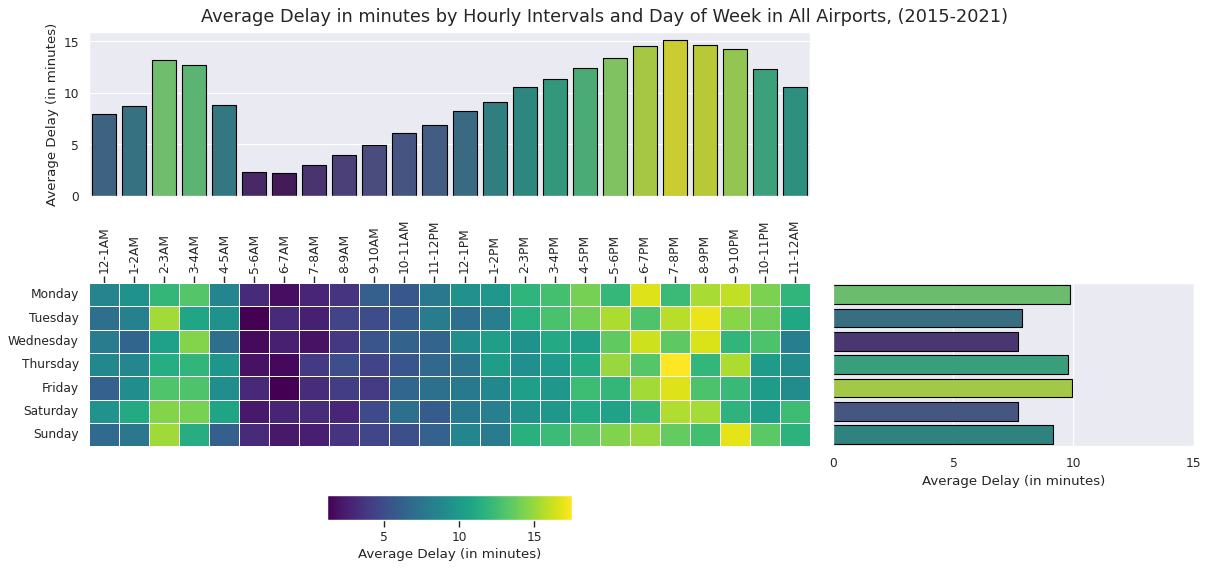

In [0]:
# Source: https://github.com/sahin-abdullah/flight-delay-prediction/blob/master/exploratory-data-analysis/Exploratory%20Data%20Analysis.ipynb
import datetime as dt

# Group by WeekDay and scheduled departure hour
# Big figure
fig = plt.figure(figsize=(15,7), constrained_layout=True, dpi=80)
# Set font size
sns.set(font_scale=1)
# Arrange grid size of subplot
grid = plt.GridSpec(2, 3, hspace=0.05, wspace=0.05, figure=fig)
ax_hr = plt.subplot(grid[0, :-1])
ax_heat = plt.subplot(grid[1, :-1])
ax_week = plt.subplot(grid[1, -1])
# Plot heatmap
hm = sns.heatmap(heat_map3, square=False, linewidths=.5, cmap="viridis", cbar=False, ax = ax_heat,
                 yticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                 xticklabels=['12-1AM', '1-2AM', '2-3AM', '3-4AM', '4-5AM', '5-6AM', '6-7AM', '7-8AM', '8-9AM',
                             '9-10AM', '10-11AM', '11-12PM', '12-1PM', '1-2PM', '2-3PM', '3-4PM', '4-5PM', '5-6PM',
                             '6-7PM', '7-8PM', '8-9PM', '9-10PM', '10-11PM', '11-12AM'])
ax_heat.xaxis.set_ticks_position('top')
ax_heat.set_xticklabels(ax_heat.get_xticklabels(), rotation=90)
ax_heat.set_ylabel('')    
ax_heat.set_xlabel('')
# Group by scheduled departure hour
# hist_hr = df_airlines.groupby([df_airlines.FLIGHT_TIMESTAMP.dt.hour])['DEP_DEL15'].apply(lambda x: np.mean(x))
# Convert it to the float
# hist_hr = hist_hr.astype('timedelta64[s]') / 60
hist_hr = hist_hr.reset_index()
# # Plot distribution
rank = hist_hr['avg(DEP_DELAY)'].argsort().argsort() # color sorting in palette
sns.barplot(x='HOUR_DEPT', y='avg(DEP_DELAY)', data=hist_hr, ax=ax_hr, 
            palette=np.array(sns.color_palette('viridis', 24))[rank], edgecolor=(0,0,0))
ax_hr.set(xticklabels=[])
ax_hr.set(xlim=(-.5, 23.5))
ax_hr.set_ylabel('Average Delay (in minutes)')    
ax_hr.set_xlabel('')
# Group by week day
# hist_wk = df_airlines.groupby([temp.WeekDay])['DEP_DEL15'].apply(lambda x: np.mean(x))
# Convert it to the float
# hist_wk = hist_wk.astype('timedelta64[s]') / 60
# hist_wk = hist_wk.reset_index()
# # Plot distribution
rank = hist_wk['avg(DEP_DELAY)'].argsort().argsort() # color sorting in palette
sns.barplot(x='avg(DEP_DELAY)', y='DAY_OF_WEEK', data=hist_wk, ax=ax_week, orient='h', 
            palette=np.array(sns.color_palette('viridis', 7))[rank], edgecolor=(0,0,0))
ax_week.set(yticklabels=[])
ax_week.set_xticks([0, 5, 10, 15])
ax_week.set(xticklabels=['0', '5', '10', '15'])
ax_week.set(ylim=(6.5, -0.5))
ax_week.set_ylabel('')
ax_week.set_xlabel('Average Delay (in minutes)')
# # Add title
fig.suptitle('Average Delay in minutes by Hourly Intervals and Day of Week in All Airports, (2015-2021)', fontsize=16)
# Add colorbar
_ = fig.colorbar(hm.collections[0], ax=ax_heat, orientation='horizontal', shrink=0.45, 
                 aspect=10, label='Average Delay (in minutes)') # Disable output
# Delete temporary variables
# del heat_map, grid, ax_hr, ax_heat, ax_week, hm, hist_hr, rank

In [0]:
df_delay_cause = df_airlines.select('FLIGHT_TIMESTAMP',
                                    "YEAR", 
                                    "MONTH",
                                    "DAY_OF_MONTH",
                                    'CANCELLED',
                                    'DEP_DELAY',
                                    'CARRIER_DELAY',
                                    'WEATHER_DELAY',
                                    'NAS_DELAY',
                                    'SECURITY_DELAY',
                                    'LATE_AIRCRAFT_DELAY') \
                            .filter(col('DEP_DELAY') >= 15).fillna(0, subset=["CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"])

df_delay_cause = df_delay_cause.withColumn('TOTAL_DELAY', (col('CARRIER_DELAY') + col('WEATHER_DELAY') + col('NAS_DELAY') + col('SECURITY_DELAY') + col('LATE_AIRCRAFT_DELAY')))
df_delay_cause = df_delay_cause.withColumn('DELAY_DIFF',  col('DEP_DELAY')  - col('TOTAL_DELAY'))
df_delay_cause

Out[11]: DataFrame[FLIGHT_TIMESTAMP: timestamp, YEAR: int, MONTH: int, DAY_OF_MONTH: int, CANCELLED: double, DEP_DELAY: double, CARRIER_DELAY: double, WEATHER_DELAY: double, NAS_DELAY: double, SECURITY_DELAY: double, LATE_AIRCRAFT_DELAY: double, TOTAL_DELAY: double, DELAY_DIFF: double]

In [0]:
# cols_to_select = [col for col in df_airlines where col.contains('DEL')]
# display(df_airlines.filter(col("NAS_DELAY") == 45).select(cols_to_select))

In [0]:
display(df_delay_cause.take(5))

FLIGHT_TIMESTAMP YEAR MONTH DAY_OF_MONTH CANCELLED DEP_DELAY CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY TOTAL_DELAY DELAY_DIFF 2019-12-06T06:15:00.000+0000 2019 12 5 0.0 165.0 10.0 0.0 0.0 0.0 134.0 144.0 21.0 2019-07-30T02:31:00.000+0000 2019 7 29 0.0 69.0 3.0 0.0 0.0 0.0 49.0 52.0 17.0 2019-12-06T21:28:00.000+0000 2019 12 6 0.0 106.0 106.0 0.0 0.0 0.0 0.0 106.0 0.0 2019-12-07T02:00:00.000+0000 2019 12 6 0.0 58.0 8.0 0.0 6.0 0.0 50.0 64.0 -6.0 2019-07-14T20:21:00.000+0000 2019 7 14 0.0 50.0 10.0 0.0 0.0 0.0 24.0 34.0 16.0

In [0]:
# df_delay_cause = df_delay_cause.withColumn('TOTAL_DELAY', (col('CARRIER_DELAY') + col('WEATHER_DELAY') + col('NAS_DELAY') + col('SECURITY_DELAY') + col('LATE_AIRCRAFT_DELAY')))
# df_delay_cause = df_delay_cause.withColumn('DELAY_DIFF',  col('DEP_DELAY')  - col('TOTAL_DELAY'))

In [0]:
# dbutils.data.summarize(df_delay_cause.select([c for c in df_delay_cause.columns if c not in {'FLIGHT_TIMESTAMP'}]))

<!DOCTYPE html>

In [0]:
display(df_delay_cause.select(sum('TOTAL_DELAY')))
display(df_delay_cause.select(sum('DEP_DELAY')))

sum(TOTAL_DELAY) 4.21249443E8

sum(DEP_DELAY) 4.63709668E8

In [0]:
# df_delay_cause.filter(col("DELAY_DIFF") != 0).count() , df_delay_cause.select(mean("DELAY_DIFF")).collect()
display(df_delay_cause.take(10))

FLIGHT_TIMESTAMP YEAR MONTH DAY_OF_MONTH CANCELLED DEP_DELAY CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY TOTAL_DELAY DELAY_DIFF 2019-12-06T06:15:00.000+0000 2019 12 5 0.0 165.0 10.0 0.0 0.0 0.0 134.0 144.0 21.0 2019-07-30T02:31:00.000+0000 2019 7 29 0.0 69.0 3.0 0.0 0.0 0.0 49.0 52.0 17.0 2019-12-06T21:28:00.000+0000 2019 12 6 0.0 106.0 106.0 0.0 0.0 0.0 0.0 106.0 0.0 2019-12-07T02:00:00.000+0000 2019 12 6 0.0 58.0 8.0 0.0 6.0 0.0 50.0 64.0 -6.0 2019-07-14T20:21:00.000+0000 2019 7 14 0.0 50.0 10.0 0.0 0.0 0.0 24.0 34.0 16.0 2019-12-06T21:35:00.000+0000 2019 12 6 0.0 77.0 0.0 0.0 80.0 0.0 0.0 80.0 -3.0 2019-12-09T23:45:00.000+0000 2019 12 9 0.0 111.0 0.0 0.0 47.0 0.0 72.0 119.0 -8.0 2019-12-10T01:44:00.000+0000 2019 12 9 0.0 56.0 0.0 0.0 72.0 0.0 7.0 79.0 -23.0 2019-12-09T21:39:00.000+0000 2019 12 9 0.0 201.0 0.0 0.0 121.0 0.0 89.0 210.0 -9.0 2019-12-21T17:40:00.000+0000 2019 12 21 0.0 17.0 10.0 0.0 0.0 0.0 5.0 15.0 2.0

In [0]:
df_delay_cause.select('YEAR','DEP_DELAY','TOTAL_DELAY','DELAY_DIFF',
                                    'CARRIER_DELAY',
                                    'WEATHER_DELAY',
                                    'NAS_DELAY',
                                    'SECURITY_DELAY',
                                    'LATE_AIRCRAFT_DELAY').groupby("YEAR")

Out[18]: <pyspark.sql.group.GroupedData at 0x7f8dd6e18070>

In [0]:
df_delay_cause_yrly = df_delay_cause.select('YEAR','DEP_DELAY','TOTAL_DELAY','DELAY_DIFF',
                                    'CARRIER_DELAY',
                                    'WEATHER_DELAY',
                                    'NAS_DELAY',
                                    'SECURITY_DELAY',
                                    'LATE_AIRCRAFT_DELAY').groupby("YEAR").sum()
df_delay_cause_yrly = df_delay_cause_yrly.withColumn("pct_CARRIER_DELAY", 100 * col('sum(CARRIER_DELAY)')/col('sum(TOTAL_DELAY)'))
df_delay_cause_yrly = df_delay_cause_yrly.withColumn("pct_WEATHER_DELAY", 100 * col('sum(WEATHER_DELAY)')/col('sum(TOTAL_DELAY)'))
df_delay_cause_yrly = df_delay_cause_yrly.withColumn("pct_NAS_DELAY", 100 * col('sum(NAS_DELAY)')/col('sum(TOTAL_DELAY)'))
df_delay_cause_yrly = df_delay_cause_yrly.withColumn("pct_SECURITY_DELAY", 100 * col('sum(SECURITY_DELAY)')/col('sum(TOTAL_DELAY)'))
df_delay_cause_yrly = df_delay_cause_yrly.withColumn("pct_LATE_AIRCRAFT_DELAY", 100 * col('sum(LATE_AIRCRAFT_DELAY)')/col('sum(TOTAL_DELAY)'))
df_delay_cause_yrly = df_delay_cause_yrly.withColumn("pct_ALL_CAUSES", col("pct_CARRIER_DELAY") + col("pct_WEATHER_DELAY") + col("pct_NAS_DELAY") + col("pct_SECURITY_DELAY")+ col("pct_LATE_AIRCRAFT_DELAY"))
# %_columns = [column for column in df_delay_cause_yrly.columns if column.startswith("pct_")]
# df_delay_cause_yrly = df_delay_cause_yrly.select(selected_columns)


## Delay Minutes by Cause

In [0]:
df_delay_cause_yrly.withColumnRenamed("pct_CARRIER_DELAY","Carrier Delay (%)") \
                       .withColumnRenamed("pct_WEATHER_DELAY","Weather Delay (%)") \
                       .withColumnRenamed("pct_NAS_DELAY","NAS Delay (%)") \
                       .withColumnRenamed("pct_SECURITY_DELAY","Security Delay (%)") \
                       .withColumnRenamed("pct_LATE_AIRCRAFT_DELAY","Late Aircraft Delay (%)") \
                       .select("YEAR","Carrier Delay (%)","NAS Delay (%)","Security Delay (%)","Late Aircraft Delay (%)","Weather Delay (%)") \
                       .toPandas().sort_values(by='YEAR',ascending=True).set_index('YEAR').round(2)

Carrier Delay (%) 
 NAS Delay (%) 
 Security Delay (%) 
 Late Aircraft Delay (%) 
 Weather Delay (%) 
 
 
 YEAR 
 
 
 
 
 
 
 
 
 
 2015 
 34.73 
 16.09 
 0.13 
 43.68 
 5.37 
 
 
 2016 
 35.21 
 17.06 
 0.14 
 42.89 
 4.70 
 
 
 2017 
 33.49 
 18.87 
 0.15 
 42.89 
 4.59 
 
 
 2018 
 32.49 
 17.81 
 0.15 
 43.43 
 6.13 
 
 
 2019 
 32.84 
 17.92 
 0.15 
 43.14 
 5.95 
 
 
 2020 
 46.04 
 12.87 
 0.25 
 32.99 
 7.86 
 
 
 2021 
 43.02 
 10.83 
 0.36 
 38.37 
 7.41

### WEATHER DELAY is encoded for "severe" weather delays and likely underestimates total delays in minutes from WEATHER.

In [0]:
'''
How many flights were really delayed by weather?
A true picture of total weather-related delays requires several steps. First, the extreme weather delays must be combined with the NAS weather category. Second, a calculation must be made to determine the weather-related delays included in the "late-arriving aircraft" category. Airlines do not report the causes of the late-arriving aircraft but an allocation can be made using the proportion of weather related-delays and total flights in the other categories. Adding the weather-related delays to the extreme weather and NAS weather categories would result in weather's share of all flight delays.

Source:
https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations

'''

'''
A flight is considered delayed when it arrived 15 or more minutes than the schedule (see definitions in Frequently Asked Questions). Delayed minutes are calculated for delayed flights only.
Weather delay in this section is the sum of Extreme Weather delays, NAS delays caused by the weather as assigned by the FAA (see National Aviation System Delay by Cause), and the Weather's pro-rata share of late-arriving-aircraft delays based on delay minutes.
No detailed data is available for a specific carreir at a specific airport.

SOURCE: Bureau of Transportation Statistics, Airline Service Quality Performance 234 and Federal Aviation Administration OPSNET
'''
WEATHER_NAS_15 = 0.6444
WEATHER_NAS_16 = 0.66
WEATHER_NAS_17 = 0.6325
WEATHER_NAS_18 = 0.6796
WEATHER_NAS_19 = 0.6986
WEATHER_NAS_20 = 0.5616
WEATHER_NAS_21 = 0.5917


df_delay_cause_yrly = df_delay_cause_yrly.withColumn("pct_NAS_DELAY_weather", when(df_delay_cause_yrly.YEAR == 2015, col("pct_NAS_DELAY") * WEATHER_NAS_15)
                                                                             .when(df_delay_cause_yrly.YEAR == 2016, col("pct_NAS_DELAY") * WEATHER_NAS_16)
                                                                             .when(df_delay_cause_yrly.YEAR == 2017, col("pct_NAS_DELAY") * WEATHER_NAS_17)
                                                                             .when(df_delay_cause_yrly.YEAR == 2018, col("pct_NAS_DELAY") * WEATHER_NAS_18)
                                                                             .when(df_delay_cause_yrly.YEAR == 2019, col("pct_NAS_DELAY") * WEATHER_NAS_19)
                                                     .when(df_delay_cause_yrly.YEAR == 2020, col("pct_NAS_DELAY") * WEATHER_NAS_20)
                                                     .when(df_delay_cause_yrly.YEAR == 2021, col("pct_NAS_DELAY") * WEATHER_NAS_21))
df_delay_cause_yrly = df_delay_cause_yrly.withColumn("pct_LATE_AIRCRAFT_DELAY_weather", col("pct_LATE_AIRCRAFT_DELAY") * (col("pct_NAS_DELAY_weather") + col("pct_WEATHER_DELAY"))/100)
df_delay_cause_yrly = df_delay_cause_yrly.withColumn("pct_WEATHER_DELAY_adj", col("pct_WEATHER_DELAY") + col("pct_NAS_DELAY_weather") + col("pct_LATE_AIRCRAFT_DELAY_weather"))


In [0]:
df_delay_cause_yrly_adj = df_delay_cause_yrly.select("YEAR","pct_WEATHER_DELAY","pct_NAS_DELAY_weather","pct_LATE_AIRCRAFT_DELAY_weather","pct_WEATHER_DELAY_adj")

df_delay_cause_yrly_adj.withColumnRenamed("pct_WEATHER_DELAY","Extreme Weather (%)") \
                       .withColumnRenamed("pct_NAS_DELAY_weather","NAS - Weather (%)") \
                       .withColumnRenamed("pct_LATE_AIRCRAFT_DELAY_weather","Late Aircraft - Weather (%)") \
                       .withColumnRenamed("pct_WEATHER_DELAY_adj","Total Weather (%)") \
                       .toPandas().sort_values(by='YEAR',ascending=True).set_index('YEAR').round(2)

Extreme Weather (%) 
 NAS - Weather (%) 
 Late Aircraft - Weather (%) 
 Total Weather (%) 
 
 
 YEAR 
 
 
 
 
 
 
 
 
 2015 
 5.37 
 10.37 
 6.87 
 22.61 
 
 
 2016 
 4.70 
 11.26 
 6.85 
 22.81 
 
 
 2017 
 4.59 
 11.94 
 7.09 
 23.62 
 
 
 2018 
 6.13 
 12.10 
 7.92 
 26.14 
 
 
 2019 
 5.95 
 12.52 
 7.97 
 26.43 
 
 
 2020 
 7.86 
 7.23 
 4.97 
 20.06 
 
 
 2021 
 7.41 
 6.41 
 5.30 
 19.13

## Holiday Travelling

In [0]:
# https://stackoverflow.com/questions/2394235/detecting-a-us-holiday

# import holidays
# us_holidays = holidays.US()
# print(us_holidays.get('01-01-2018'))
# print('01-01-2018' in us_holidays)
# for ptr in holidays.US(years = 2018).items():
#   print(ptr)

In [0]:
from itertools import chain

# Source: https://www.transtats.bts.gov/holidaydelay.asp

# Thanksgiving/Winter Holidays
HOLIDAY_DATEPAIRS = [('2015-11-20','2015-12-01'),
('2016-11-18','2016-11-29'),
('2017-11-17','2017-11-28'),
('2018-11-16','2018-11-27'),
('2019-11-22','2019-12-03'),
('2020-11-20','2020-12-01'),
('2021-11-19','2021-11-30'),
('2015-12-16','2016-01-05'),
('2016-12-15','2017-01-04'),
('2017-12-14','2018-01-03'),
('2018-12-14','2019-01-03'),
('2019-12-14','2020-01-03'),
('2020-12-16','2020-01-05'),
('2021-12-15','2021-01-04')
]


# GLOBAL LIST
# [('2015-02-15','2015-02-17'), ('2016-02-11','2016-02-16'),('2017-02-16','2017-02-21'),('2018-02-15','2018-02-20'),('2019-02-14','2019-02-19'),('2020-02-13','2020-02-18'),('2021-02-11','2021-02-16'),('2015-03-29','2015-04-12'),('2016-03-20','2016-04-03'),('2017-04-09','2017-04-23'),('2018-03-25','2018-04-08'),('2019-03-15','2019-03-29'),('2020-04-05','2020-04-19'),('2021-03-28','2021-04-11'),('2015-05-18','2015-05-27'),('2016-05-23','2016-06-01'),('2017-05-22','2017-05-31'),('2018-05-21','2018-05-30'),('2019-05-20','2019-05-29'),('2020-05-18','2020-05-27'),('2021-05-24','2021-06-02'),('2015-06-26','2015-07-05'),('2016-07-01','2016-07-10'),('2017-07-01','2017-07-10'),('2018-06-29','2018-07-08'),('2019-06-28','2019-07-07'),('2020-06-26','2020-07-05'),('2021-07-02','2021-07-11'),('2015-09-02','2015-09-09'),('2016-08-31','2016-09-07'),('2017-08-30','2017-09-06'),('2018-08-29','2018-09-05'),('2019-08-28','2019-09-04'),('2020-09-02','2020-09-09'),('2021-09-01','2021-09-08'),('2015-11-20','2015-12-01'),('2016-11-18','2016-11-29'),('2017-11-17','2017-11-28'),('2018-11-16','2018-11-27'),('2019-11-22','2019-12-03'),('2020-11-20','2020-12-01'),('2021-11-19','2021-11-30'),('2015-12-16','2016-01-05'),('2016-12-15','2017-01-04'),('2017-12-14','2018-01-03'),('2018-12-14','2019-01-03'),('2019-12-14','2020-01-03'),('2020-12-16','2020-01-05'),('2021-12-15','2021-01-04')]

def daterange(date1, date2):
    date_list = []
    for n in range(int ((date2 - date1).days)+1):
         date_list.append(date1 + timedelta(n) )
    return date_list

GLOBAL_HOLIDAYS = []

for datepair in HOLIDAY_DATEPAIRS:
  start_date, end_date = datetime.strptime(datepair[0], '%Y-%m-%d'), datetime.strptime(datepair[1], '%Y-%m-%d') 
  GLOBAL_HOLIDAYS.append([dt.strftime("%Y-%m-%d") for dt in daterange(start_date, end_date)])
  
  
GLOBAL_HOLIDAY_LIST = list(chain(*GLOBAL_HOLIDAYS)) 

# df_airlines = df_airlines.withColumn("HOLIDAY", col("FL_DATE").isin(GLOBAL_HOLIDAY_LIST))
df_airlines = df_airlines.withColumn("FL_DATE_ADJ",to_date("FL_DATE"))
df_airlines = df_airlines.withColumn("HOLIDAY", when(col("FL_DATE_ADJ").isin(GLOBAL_HOLIDAY_LIST), 1)
                                     .otherwise(0) )

In [0]:
# display(df_airlines.select("FL_DATE","FL_DATE_ADJ").filter(col("YEAR") == '2019'))
display(df_airlines.select("FL_DATE","FL_DATE_ADJ").filter(col("YEAR") == '2020'))
# df_airlines = df_airlines.withColumn("FL_DATE_ADJ",to_date("FL_DATE"))

FL_DATE FL_DATE_ADJ 2020-12-10 00:00:00 2020-12-10 2020-12-22 00:00:00 2020-12-22 2020-12-30 00:00:00 2020-12-30 2020-12-19 00:00:00 2020-12-19 2020-12-21 00:00:00 2020-12-21 2020-12-03 00:00:00 2020-12-03 2020-12-18 00:00:00 2020-12-18 2020-12-08 00:00:00 2020-12-08 2020-12-11 00:00:00 2020-12-11 2020-12-18 00:00:00 2020-12-18 2020-12-23 00:00:00 2020-12-23 2020-12-17 00:00:00 2020-12-17 2020-12-09 00:00:00 2020-12-09 2020-12-09 00:00:00 2020-12-09 2020-12-16 00:00:00 2020-12-16 2020-12-19 00:00:00 2020-12-19 2020-12-30 00:00:00 2020-12-30 2020-12-05 00:00:00 2020-12-05 2020-12-26 00:00:00 2020-12-26 2020-12-13 00:00:00 2020-12-13 2020-12-05 00:00:00 2020-12-05 2020-12-10 00:00:00 2020-12-10 2020-12-20 00:00:00 2020-12-20 2020-12-02 00:00:00 2020-12-02 2020-12-11 00:00:00 2020-12-11 2020-12-26 00:00:00 2020-12-26 2020-12-06 00:00:00 2020-12-06 2020-12-18 00:00:00 2020-12-18 2020-12-15 00:00:00 2020-12-15 2020-12-11 00:00:00 2020-12-11 2020-12-02 00:00:00 2020-12-02 2020-12-11 00:00:00 2020-12-11 2020-12-03 00:00:00 2020-12-03 2020-12-03 00:00:00 2020-12-03 2020-12-06 00:00:00 2020-12-06 2020-12-29 00:00:00 2020-12-29 2020-12-15 00:00:00 2020-12-15 2020-12-02 00:00:00 2020-12-02 2020-12-24 00:00:00 2020-12-24 2020-12-21 00:00:00 2020-12-21 2020-12-10 00:00:00 2020-12-10 2020-12-18 00:00:00 2020-12-18 2020-12-08 00:00:00 2020-12-08 2020-12-02 00:00:00 2020-12-02 2020-12-08 00:00:00 2020-12-08 2020-12-07 00:00:00 2020-12-07 2020-12-23 00:00:00 2020-12-23 2020-12-11 00:00:00 2020-12-11 2020-12-30 00:00:00 2020-12-30 2020-12-26 00:00:00 2020-12-26 2020-12-26 00:00:00 2020-12-26 2020-12-03 00:00:00 2020-12-03 2020-12-16 00:00:00 2020-12-16 2020-12-23 00:00:00 2020-12-23 2020-12-04 00:00:00 2020-12-04 2020-12-11 00:00:00 2020-12-11 2020-12-02 00:00:00 2020-12-02 2020-12-15 00:00:00 2020-12-15 2020-12-29 00:00:00 2020-12-29 2020-12-11 00:00:00 2020-12-11 2020-12-05 00:00:00 2020-12-05 2020-12-06 00:00:00 2020-12-06 2020-12-14 00:00:00 2020-12-14 2020-12-19 00:00:00 2020-12-19 2020-12-01 00:00:00 2020-12-01 2020-12-01 00:00:00 2020-12-01 2020-12-03 00:00:00 2020-12-03 2020-12-16 00:00:00 2020-12-16 2020-12-17 00:00:00 2020-12-17 2020-12-08 00:00:00 2020-12-08 2020-12-28 00:00:00 2020-12-28 2020-12-18 00:00:00 2020-12-18 2020-12-27 00:00:00 2020-12-27 2020-12-05 00:00:00 2020-12-05 2020-12-28 00:00:00 2020-12-28 2020-12-01 00:00:00 2020-12-01 2020-12-23 00:00:00 2020-12-23 2020-12-31 00:00:00 2020-12-31 2020-12-24 00:00:00 2020-12-24 2020-12-14 00:00:00 2020-12-14 2020-12-10 00:00:00 2020-12-10 2020-12-24 00:00:00 2020-12-24 2020-12-28 00:00:00 2020-12-28 2020-12-12 00:00:00 2020-12-12 2020-12-10 00:00:00 2020-12-10 2020-12-08 00:00:00 2020-12-08 2020-12-07 00:00:00 2020-12-07 2020-12-18 00:00:00 2020-12-18 2020-12-09 00:00:00 2020-12-09 2020-12-18 00:00:00 2020-12-18 2020-12-04 00:00:00 2020-12-04 2020-12-17 00:00:00 2020-12-17 2020-12-26 00:00:00 2020-12-26 2020-12-15 00:00:00 2020-12-15 2020-12-20 00:00:00 2020-12-20 2020-12-15 00:00:00 2020-12-15 2020-12-29 00:00:00 2020-12-29 2020-12-05 00:00:00 2020-12-05 2020-12-03 00:00:00 2020-12-03 2020-12-16 00:00:00 2020-12-16 2020-12-18 00:00:00 2020-12-18 2020-12-09 00:00:00 2020-12-09 2020-12-03 00:00:00 2020-12-03 2020-12-18 00:00:00 2020-12-18 2020-12-07 00:00:00 2020-12-07 2020-12-20 00:00:00 2020-12-20 2020-12-30 00:00:00 2020-12-30 2020-12-27 00:00:00 2020-12-27 2020-12-13 00:00:00 2020-12-13 2020-12-16 00:00:00 2020-12-16 2020-12-29 00:00:00 2020-12-29 2020-12-26 00:00:00 2020-12-26 2020-12-28 00:00:00 2020-12-28 2020-12-20 00:00:00 2020-12-20 2020-12-04 00:00:00 2020-12-04 2020-12-26 00:00:00 2020-12-26 2020-12-22 00:00:00 2020-12-22 2020-12-16 00:00:00 2020-12-16 2020-12-01 00:00:00 2020-12-01 2020-12-31 00:00:00 2020-12-31 2020-12-06 00:00:00 2020-12-06 2020-12-10 00:00:00 2020-12-10 2020-12-11 00:00:00 2020-12-11 2020-12-26 00:00:00 2020-12-26 2020-12-17 00:00:00 2020-12-17 2020-12-21 00:00:00 2020-12-21 2020-12-23 00:00:00 2020-12-23 2020-12-17 00:00:00 2020-12-17 2020-12-03 0

In [0]:
df_holidays = df_airlines.na.fill(value=0,subset=["DEP_DEL15"])
df_holidays = df_holidays.select("HOLIDAY","YEAR","DEP_DEL15").groupBy("HOLIDAY","YEAR","DEP_DEL15").count().toPandas().sort_values(by='YEAR',ascending=False)
# df_holidays['percent_delay'] = df_holidays['count']

In [0]:
# df_holidays['delay_percent'] = np.where(df_holidays.DEP_DEL15 == 1, df_holidays['count'] * 100 / df_holidays.groupby('YEAR')['count'].transform('sum'), 0)
df_holidays['delay_percent'] = np.where(df_holidays.DEP_DEL15 == 1, 100 * df_holidays['count'] / df_holidays.groupby(['YEAR','HOLIDAY'])['count'].transform('sum'), 0)
df_holidays = df_holidays.sort_values(by='YEAR',ascending=False)
df_holidays = df_holidays[df_holidays['delay_percent'] > 0]


In [0]:
df_holidays

HOLIDAY 
 YEAR 
 DEP_DEL15 
 count 
 delay_percent 
 
 
 
 
 27 
 0 
 2021 
 1.0 
 898906 
 17.008081 
 
 
 11 
 1 
 2021 
 1.0 
 125739 
 17.704058 
 
 
 15 
 1 
 2020 
 1.0 
 37111 
 8.213033 
 
 
 1 
 0 
 2020 
 1.0 
 364041 
 8.592968 
 
 
 3 
 1 
 2019 
 1.0 
 234400 
 19.301570 
 
 
 5 
 0 
 2019 
 1.0 
 1127764 
 18.167390 
 
 
 16 
 0 
 2018 
 1.0 
 1082238 
 17.941475 
 
 
 10 
 1 
 2018 
 1.0 
 224197 
 18.977230 
 
 
 9 
 0 
 2017 
 1.0 
 837712 
 17.709628 
 
 
 6 
 1 
 2017 
 1.0 
 176133 
 18.651084 
 
 
 18 
 0 
 2016 
 1.0 
 771299 
 16.477019 
 
 
 19 
 1 
 2016 
 1.0 
 182244 
 19.458060 
 
 
 24 
 1 
 2015 
 1.0 
 179114 
 20.510935 
 
 
 2 
 0 
 2015 
 1.0 
 878440 
 17.761268

Out[65]: <seaborn.axisgrid.FacetGrid at 0x7f18a754d280>

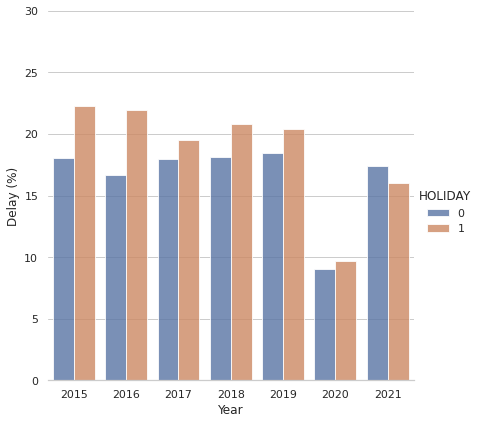

In [0]:
# plt.style.use('ggplot')
# width = 0.4
# plt.bar(x=df_holidays['YEAR'], height=df_holidays[df_holidays['HOLIDAY']==1]['delay_percent'], width=width, label='Men')
# plt.bar(x=df_holidays['YEAR']+width, height=df_holidays[df_holidays['HOLIDAY']==0]['delay_percent'], width=width, label='Women')
# plt.title('Delay by Year by Holiday', fontsize=18)
# plt.xlabel('Year')
# plt.ylabel('% Delay')
# plt.legend(loc='lower right')
# plt.show()

holiday_label = {0 : "Not Holiday", 1: "Holiday"}

df_holidays.rename(columns=holiday_label)

import seaborn as sns
# sns.barplot(data=df_holidays, y='delay_percent', x='YEAR', hue='HOLIDAY').set(title='Points by Team')

sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_holidays, kind="bar",
    x="YEAR", y="delay_percent", hue="HOLIDAY",
    palette="deep", alpha=.8, height=6
)
g.despine(left=True)
g.set_axis_labels("Year", "Delay (%)").set(ylim=(0,30))
# g.legend.set_title("Percentage of Flights Delayed by Year and Holiday Season")

In [0]:
import scipy.stats as stats

stats.ttest_ind(df_holidays['delay_percent'][df_holidays['HOLIDAY'] == 1],
                df_holidays['delay_percent'][df_holidays['HOLIDAY'] == 0]
)

Out[66]: Ttest_indResult(statistic=1.0120947422444144, pvalue=0.33146547514803626)